# Imports

In [64]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Normalization
from sklearn.preprocessing import TargetEncoder, MinMaxScaler, StandardScaler, PowerTransformer, LabelEncoder
from sklearn.impute import SimpleImputer

# Feature selection
#!pip install boruta
from boruta import BorutaPy
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LassoCV
import scipy.stats as stats
from scipy.stats import chi2_contingency

# Classification Models
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import SGDClassifier

# F1 score
from sklearn.metrics import f1_score

from imblearn.combine import SMOTETomek
from utils import CustomCleaner, get_submission_data

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data 

In [9]:
df_training = pd.read_csv('./project_data/train.csv')

In [10]:
df_training.head()

,encounter_id,country,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,...,secondary_diagnosis,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,change_in_meds_during_hospitalization,prescribed_diabetes_meds,medication,readmitted_binary,readmitted_multiclass
0,533253,USA,70110,Caucasian,Female,[70-80),?,?,0,0,...,276,466,8,NaN,NaN,No,No,[],No,>30 days
1,426224,USA,29775006,AfricanAmerican,Male,[50-60),?,?,0,0,...,785,162,9,NaN,NaN,No,Yes,['insulin'],No,No
2,634063,USA,80729253,Caucasian,Female,[60-70),?,?,0,0,...,135,250,6,NaN,NaN,Ch,Yes,"['glimepiride', 'insulin']",No,No
3,890610,USA,2919042,AfricanAmerican,Male,[60-70),?,MC,0,0,...,562,455,5,NaN,NaN,No,No,[],No,No
4,654194,USA,84871971,Caucasian,Female,[70-80),?,HM,1,0,...,599,428,9,NaN,NaN,No,No,[],No,>30 days


# Using Custom Cleaner

In [11]:
cleaner = CustomCleaner()

# Replaces '?','Unknown' by NaN
# maps Ages
# maps payer_code
# gets all unique medications as features                      (new feature)
# also get the count of medications (for diabetes)             (many new features)
# cleans discharge_disposition
# cleans admission_source
# cleans admission_type
# cleans medical_specialty
# gets primary diagnosis (from 3 original diagnosis columns)   (new feature)
# gets number of visits per patient using repeated patient_id  (new feature)
# gets number (log) of medications per day in the hospital     (new feature)
# gets number of lab tests per day in the hospital             (new feature)
# gets proportions of each of the 3 types of visits, per visit (3 new features)


In [12]:
df = cleaner.fit_transform(df_training)

In [13]:
df.dtypes

encounter_id                               int64
country                                   object
patient_id                                 int64
race                                      object
gender                                    object
age                                      float64
weight                                    object
payer_code                                  bool
outpatient_visits_in_previous_year         int64
emergency_visits_in_previous_year          int64
inpatient_visits_in_previous_year          int64
admission_type                            object
medical_specialty                         object
average_pulse_bpm                          int64
discharge_disposition                     object
admission_source                          object
length_of_stay_in_hospital                 int64
number_lab_tests                           int64
non_lab_procedures                         int64
number_of_medications                      int64
primary_diagnosis   

# Dealing with Outliers

# Normalization

In [16]:
df.select_dtypes(exclude=np.number).columns

Index(['country', 'race', 'gender', 'weight', 'payer_code', 'admission_type',
       'medical_specialty', 'discharge_disposition', 'admission_source',
       'primary_diagnosis', 'secondary_diagnosis', 'additional_diagnosis',
       'glucose_test_result', 'a1c_test_result',
       'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds',
       'medication', 'readmitted_binary', 'readmitted_multiclass',
       'glimepiride', 'insulin', 'chlorpropamide', 'rosiglitazone',
       'pioglitazone', 'nateglinide', 'miglitol', 'metformin',
       'glyburide-metformin', 'acarbose', 'tolbutamide', 'tolazamide',
       'glipizide', 'troglitazone', 'repaglinide', 'glipizide-metformin',
       'glyburide', 'metformin-rosiglitazone', 'metformin-pioglitazone',
       'acetohexamide', 'glimepiride-pioglitazone'],
      dtype='object')

In [17]:
df.select_dtypes(include=np.number).columns

Index(['encounter_id', 'patient_id', 'age',
       'outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'average_pulse_bpm',
       'length_of_stay_in_hospital', 'number_lab_tests', 'non_lab_procedures',
       'number_of_medications', 'number_diagnoses', 'number_diab_meds',
       'number_visits_per_patient', 'n_medication_per_day',
       'n_lab_tests_per_day', 'prop_inpatient', 'prop_outpatient',
       'prop_emergency'],
      dtype='object')

In [18]:
cat_cols = ['race','gender','admission_type','discharge_disposition','admission_source',
            'primary_diagnosis','change_in_meds_during_hospitalization','prescribed_diabetes_meds',
            'insulin','metformin','payer_code','medical_specialty'
           ]

num_cols = ['age', 'average_pulse_bpm', 'length_of_stay_in_hospital', 'number_lab_tests', 'non_lab_procedures',
            'number_of_medications', 'number_diagnoses', 'number_diab_meds', 'number_visits_per_patient',
            'n_medication_per_day', 'n_lab_tests_per_day', 'prop_inpatient', 'prop_outpatient','prop_emergency', 
            'outpatient_visits_in_previous_year', 'emergency_visits_in_previous_year', 'inpatient_visits_in_previous_year'
           ]

In [19]:
X = df.drop(columns=['readmitted_binary', 'readmitted_multiclass'])
y = df.readmitted_binary

label = LabelEncoder()
y = label.fit_transform(y)

In [23]:
cat_pipe = Pipeline([
    ('target', TargetEncoder(target_type='binary')) # categorical encoder
])

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # impute NaN with median
    ('deskewer', PowerTransformer()),               # transform distribution into more Gaussian-like (Normal)
    ('scaler', MinMaxScaler())                      # normalization, values between 0 and 1  
])

preproc = ColumnTransformer([
    ('cat', cat_pipe, cat_cols),
    ('num', num_pipe, num_cols)
], remainder='drop')

preproc

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('target',
                                                  TargetEncoder(target_type='binary'))]),
                                 ['race', 'gender', 'admission_type',
                                  'discharge_disposition', 'admission_source',
                                  'primary_diagnosis',
                                  'change_in_meds_during_hospitalization',
                                  'prescribed_diabetes_meds', 'insulin',
                                  'metformin', 'payer_code',
                                  'medical_specialty']),
                                ('num',
                                 Pipeline(steps=[('...
                                  'length_of_stay_in_hospital',
                                  'number_lab_tests', 'non_lab_procedures',
                                  'number_of_medications', 'number_diagnoses',
                                  'number_diab_meds',
                                  'number_visits_per_patient',
                                  'n_medication_per_day', 'n_lab_tests_per_day',
                                  'prop_inpatient', 'prop_outpatient',
                                  'prop_emergency',
                                  'outpatient_visits_in_previous_year',
                                  'emergency_visits_in_previous_year',
                                  'inpatient_visits_in_previous_year'])])

# Train/Test Split

In [24]:
from sklearn.model_selection import train_test_split, cross_val_score

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.7 , stratify=y, random_state=42)

In [26]:
X_train = preproc.fit_transform(X_train, y_train)
X_test = preproc.transform(X_test)

# Feature Selection

## RFE

In [76]:
#no of features
nof_list=np.arange(1,29)            
high_score=0
#Variable to store the optimum features
nof=0           
train_score_list =[]
val_score_list = []

for n in range(len(nof_list)):
    model = LogisticRegression()
    
    rfe = RFE(estimator = model,n_features_to_select = nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    
    #storing results on training data
    train_score = model.score(X_train_rfe,y_train)
    train_score_list.append(train_score)
    
    #storing results on training data
    val_score = model.score(X_test_rfe,y_test)
    val_score_list.append(val_score)
    
    #check best score
    if(val_score >= high_score):
        high_score = val_score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 27
Score with 27 features: 0.888447


In [77]:
lr = LogisticRegression()
rfe = RFE(estimator = lr, n_features_to_select=27)
X_rfe = rfe.fit_transform(X = X_train, y = y_train)

selected_features = pd.Series(rfe.support_, index = pd.concat((X[cat_cols],X[num_cols])).columns)
selected_features

race                                      True
gender                                    True
admission_type                            True
discharge_disposition                     True
admission_source                          True
primary_diagnosis                         True
change_in_meds_during_hospitalization     True
prescribed_diabetes_meds                  True
insulin                                   True
metformin                                 True
payer_code                                True
medical_specialty                         True
age                                       True
average_pulse_bpm                        False
length_of_stay_in_hospital                True
number_lab_tests                          True
non_lab_procedures                        True
number_of_medications                     True
number_diagnoses                          True
number_diab_meds                         False
number_visits_per_patient                 True
n_medication_

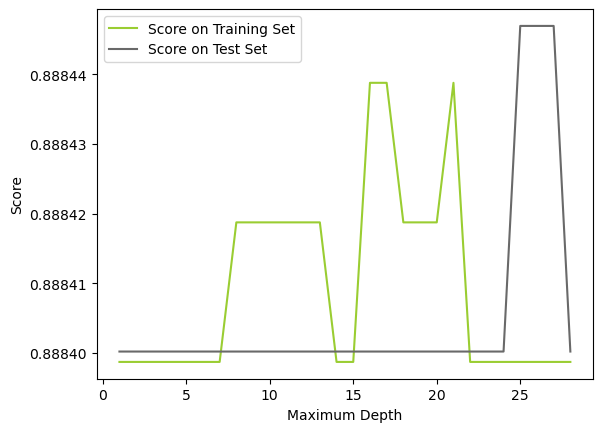

In [79]:
plt.plot(list(range(1,29)), train_score_list, label="Score on Training Set", color='yellowgreen')
plt.plot(list(range(1,29)), val_score_list, label="Score on Test Set", color='dimgray')
plt.xlabel("Maximum Depth")
plt.ylabel("Score")
plt.legend()
plt.show()

## Lasso

In [81]:
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

In [82]:
reg = LassoCV()
reg.fit(X_train, y_train)
coef = pd.Series(reg.coef_, index = pd.concat((X[cat_cols],X[num_cols])).columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 20 variables and eliminated the other 9 variables


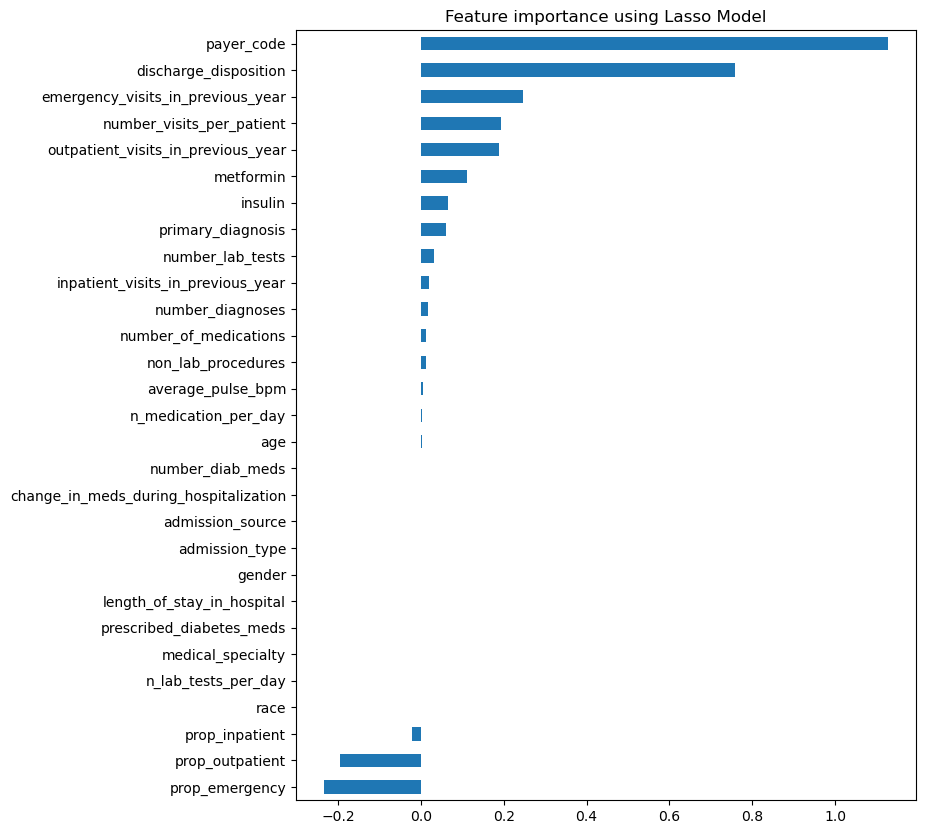

In [83]:
plot_importance(coef,'Lasso')

## Boruta

In [84]:
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=1, max_iter=100)
feat_selector.fit(X_train, y_train)

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100
Iteration: 33 / 100
Iteration: 34 / 100
Iteration: 35 / 100
Iteration: 36 / 100
Iteration: 37 / 100
Iteration: 38 / 100
Iteration: 39 / 100
Iteration: 40 / 100


BorutaPy finished running.

Iteration: 	41 / 100
Confirmed: 	19
Tentative: 	0
Rejected: 	10


BorutaPy(estimator=RandomForestClassifier(class_weight='balanced', max_depth=5,
                                          n_estimators=126, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x2EE94E1B840),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x2EE94E1B840, verbose=1)

# Models

### SVC

In [126]:
svc = SVC(class_weight='balanced', random_state=42)

In [127]:
cross_val_score(svc, X_train, y_train, scoring='f1', cv=5).mean()

0.31409428314447835

In [128]:
svc.fit(X_train, y_train)

SVC(class_weight='balanced', random_state=42)

In [129]:
y_pred = svc.predict(X_test)

In [130]:
f1_score(y_test, y_pred)

0.3205774518790101

### SVC using Bagging (ensemble method)

In [111]:
from sklearn.ensemble import BaggingClassifier
svc_bag = SVC(class_weight='balanced')

bagging_model = BaggingClassifier(estimator=svc_bag, n_estimators=5, random_state=42)
bagging_model.fit(X_train, y_train)

y_pred_bagging = bagging_model.predict(X_test)
f1_bagging = f1_score(y_test, y_pred_bagging)

In [112]:
f1_bagging

0.3211337369290039

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()

In [68]:
cross_val_score(mlp, X_train, y_train, scoring='f1', cv=5).mean()

0.0076306110867693875

In [69]:
mlp.fit(X_train, y_train)

MLPClassifier()

In [70]:
y_pred = mlp.predict(X_test)

### SVC - Grid Seacrh

In [133]:
svc_grid = SVC(class_weight='balanced', random_state=42)

In [134]:
from sklearn.model_selection import GridSearchCV

In [135]:
param_grid = {
    'kernel': ['linear', 'rbf'],
}

In [136]:
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)
print("Best Hyperparameters: ", grid_search.best_params_)

Best Hyperparameters:  {'kernel': 'rbf'}


In [137]:
best_svc_model = grid_search.best_estimator_

In [138]:
y_pred = best_svc_model.predict(X_test)

In [139]:
f1_score(y_test, y_pred)

0.3205774518790101

# Submission

In [113]:
sub_df = pd.read_csv('./project_data/test.csv')

In [114]:
sub_encounter_id = sub_df.encounter_id
sub_clean = cleaner.transform(sub_df)
sub_preproc = preproc.transform(sub_clean)

In [115]:
get_submission_data(best_svc_model, sub_preproc, sub_encounter_id, './submissions/')

./submissions/submission_v41.csv was created! Good luck on the score!
